# EDA - UFO data

In [24]:
import pandas as pd
import os
import geopandas as gpd

from os.path import join

## Directories and housekeeping

We'll set out our common filepaths:

In [2]:
root_dir = os.path.abspath("..")
data_dir = join(root_dir, "data")
raw_data_dir = join(data_dir, "raw")

# Data 

We'll read in our full dataset to begin. This is a `.csv` file - we make no further assumptions:

In [3]:
df_ufo = pd.read_csv(join(raw_data_dir, "ufo_fullset.csv"))

The data is succesfully read in.

# Exploration

## Column selection

We wish to first determine which columns are worthwhile keeping and are relevant to our dataset - or at the very least cleaning.

In [4]:
df_ufo.columns

Index(['reportedTimestamp', 'eventDate', 'eventTime', 'shape', 'duration',
       'witnesses', 'weather', 'firstName', 'lastName', 'latitude',
       'longitude', 'sighting', 'physicalEvidence', 'contact',
       'researchOutcome'],
      dtype='object')

Given we don't have an enormous quantity of features, we can display these in here for convenience:

In [5]:
df_ufo.head()

,reportedTimestamp,eventDate,eventTime,shape,duration,witnesses,weather,firstName,lastName,latitude,longitude,sighting,physicalEvidence,contact,researchOutcome
0,1977-04-04T04:02:23.340Z,1977-03-31,23:46,circle,4,1,rain,Ila,Bashirian,47.329444,-122.578889,Y,N,N,explained
1,1982-11-22T02:06:32.019Z,1982-11-15,22:04,disk,4,1,partly cloudy,Eriberto,Runolfsson,52.664913,-1.034894,Y,Y,N,explained
2,1992-12-07T19:06:52.482Z,1992-12-07,19:01,circle,49,1,clear,Miller,Watsica,38.951667,-92.333889,Y,N,N,explained
3,2011-02-24T21:06:34.898Z,2011-02-21,20:56,disk,13,1,partly cloudy,Clifton,Bechtelar,41.496944,-71.367778,Y,N,N,explained
4,1991-03-09T16:18:45.501Z,1991-03-09,11:42,circle,17,1,mostly cloudy,Jayda,Ebert,47.606389,-122.330833,Y,N,N,explained


Most of the columns are totally superfluous to our analysis (although they provide interesting ways to slice and dice the data). 

If we were to assess the purpose/process of these UFO detector tools, we could use these other features to optimise our locations. However, we don't - we are just being asked to place them based upon likelihood of detecting events. 

The only column that is relevant to our assessment is whether the outcome of research was `explained` or not. We are interested in capturing `unexplained` events.

Therefore, being incredibly buckwild, we remove them:

In [6]:
irrelevant_columns = ["eventTime", "eventDate", "reportedTimestamp", "shape", "duration", "witnesses", "weather", "rain", "firstName", "lastName", "sighting", "contact", "physicalEvidence"]

In [7]:
df_ufo = df_ufo[[col for col in df_ufo.columns if col not in irrelevant_columns]]

## Datatypes

We will examine what is left and check if the datatypes are as we expect:

In [8]:
df_ufo.dtypes

latitude           float64
longitude          float64
researchOutcome     object
dtype: object

This is reasonable. We may like to convert `researchOutcome` to a categorical, but there is no real pressing need.

## Data quality

### Missingness

Of our values left, do we have missing values or other issues?

In [9]:
df_ufo.isna().sum()

latitude           0
longitude          0
researchOutcome    0
dtype: int64

In [10]:
df_ufo.isnull().sum()

latitude           0
longitude          0
researchOutcome    0
dtype: int64

Looks clean in terms of missing values. 

### `researchOutcome` values

In [14]:
pd.unique(df_ufo.loc[:, ['researchOutcome']].values.reshape([-1]))

array(['explained', 'probable', 'unexplained'], dtype=object)

Interesting! We have a `probable` and an `unexplained` option.

In [15]:
df_ufo.groupby('researchOutcome').count()

,latitude,longitude
researchOutcome,,
explained,12822,12822
probable,1870,1870
unexplained,3308,3308


With these together, we have approximately 5200 examples to draw from.

## Variable distributions

We will examine the distributions of latitude and longitude:

<AxesSubplot:>

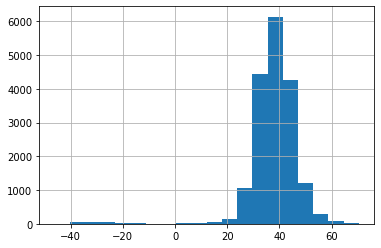

In [16]:
df_ufo.latitude.hist(bins=20)

<AxesSubplot:>

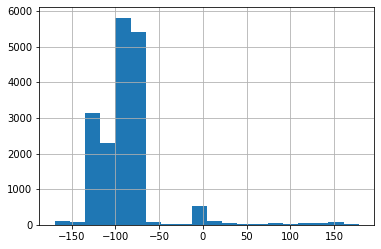

In [17]:
df_ufo.longitude.hist(bins=20)

It appears that the points are strongly clumped at around a few latitudes and longitudes. We will visualise this.

### Visualisation

In [18]:
df_ufo_filtered = (df_ufo
                  .query("researchOutcome in ['unexplained', 'probable']"))

In [19]:
gdf = gpd.GeoDataFrame(df_ufo_filtered,
                      geometry=gpd.points_from_xy(df_ufo_filtered.longitude, 
                                                  df_ufo_filtered.latitude))

In [20]:
gdf.head()

,latitude,longitude,researchOutcome,geometry
6,33.669444,-117.822222,probable,POINT (-117.82222 33.66944)
7,44.716667,-75.516667,unexplained,POINT (-75.51667 44.71667)
10,51.783333,-0.783333,unexplained,POINT (-0.78333 51.78333)
12,38.254167,-85.759444,unexplained,POINT (-85.75944 38.25417)
13,39.063658,-77.298777,probable,POINT (-77.29878 39.06366)


In [21]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = world[['geometry', 'name']]

In [25]:
gdf = gpd.sjoin(gdf, countries, how='inner', op='intersects')

<ipython-input-25-0f9c156b1947>:1: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  gdf = gpd.sjoin(gdf, countries, how='inner', op='intersects')


In [29]:
gdf

,latitude,longitude,researchOutcome,geometry,index_right,name
6,33.669444,-117.822222,probable,POINT (-117.82222 33.66944),4,United States of America
12,38.254167,-85.759444,unexplained,POINT (-85.75944 38.25417),4,United States of America
13,39.063658,-77.298777,probable,POINT (-77.29878 39.06366),4,United States of America
16,33.902222,-118.080833,unexplained,POINT (-118.08083 33.90222),4,United States of America
22,42.637500,-70.950000,unexplained,POINT (-70.95000 42.63750),4,United States of America
...,...,...,...,...,...,...
16910,41.650000,60.300000,unexplained,POINT (60.30000 41.65000),6,Uzbekistan
17200,42.657798,21.153346,probable,POINT (21.15335 42.65780),174,Kosovo
17447,47.497912,19.040235,unexplained,POINT (19.04023 47.49791),115,Hungary
17708,-33.469120,-70.641997,unexplained,POINT (-70.64200 -33.46912),10,Chile


In [46]:
country_count = (gdf
 [['name', 'geometry']]
 .groupby('name')
 .count()
 .rename({"geometry": "count"}, axis='columns')
)
country_count.head()

,count
name,
Afghanistan,1
Australia,39
Austria,1
Bangladesh,2
Belgium,6


In [48]:
gdf_country_count = countries.merge(country_count, on='name')

<AxesSubplot:>

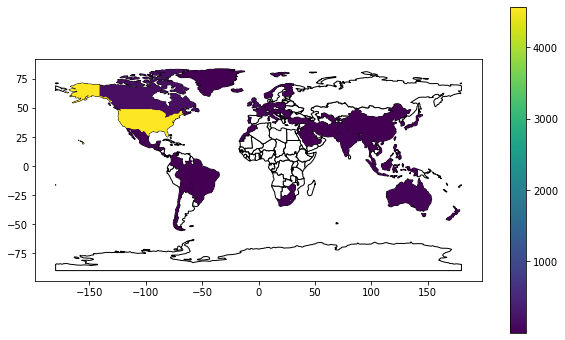

In [54]:
ax = world.plot(color='white', edgecolor='black', figsize=[10, 6])
gdf_country_count.plot(ax=ax, column='count', legend=True)

Perhaps as expected, the data is concentrated heavily in the USA - perhaps to the point where it's only worthwhile to plot USA data.